In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from scipy import stats

## exit_times: the following function allows to fing the exit times distribution of a bistable stochastic process. Euler-Maruyama integration method


In [19]:
def choose_sign(l,choice1,jump_sign1,mean_values1,delta_jump1,skimmed_exit_times1,exit_time1,jump_sign_list1,jump_mean_list1,step_mean_values1):
                
    jump_sign1=mean_values1[l+1]-mean_values1[l]
    if (mean_values1[l+1]-mean_values1[l])*choice1>delta_jump1:
        exit_time1.append(skimmed_exit_times1[l])
        jump_sign_list1.append(choice1)
        jump_mean_list1.append(abs(mean_values1[l+1]-mean_values1[l]))
        if len(jump_sign_list1)>1:
            if jump_sign_list1[len(jump_sign_list1)-1]==jump_sign_list1[len(jump_sign_list1)-2]:
                a=jump_mean_list1[len(jump_sign_list1)-1]
                b=jump_mean_list1[len(jump_sign_list1)-2]
                if a>b:
                    exit_time1.pop(len(jump_sign_list1)-1)
                    jump_sign_list1.pop(len(jump_sign_list1)-2)
                    jump_mean_list1.pop(len(jump_sign_list1)-2)
                else:
                    exit_time1.pop(len(jump_sign_list1))
                    jump_sign_list1.pop(len(jump_sign_list1)-1)
                    jump_mean_list1.pop(len(jump_sign_list1)-1)
        jump_sign1=-1*choice1
    else:
        if jump_sign1*choice1<0:
            l=l-1
        else:
            mean_values1[l+1]=(mean_values1[l]*step_mean_values1[l]+mean_values1[l+1]*step_mean_values1[l+1])/(step_mean_values1[l]+step_mean_values1[l+1])
    
    return jump_sign1,mean_values1,delta_jump1,skimmed_exit_times1,exit_time1,jump_sign_list1,jump_mean_list1,step_mean_values1,l
             
        
        
        
        
        
        
        
def exit_times(N,dt,e,n_it,x_0,min_ex,max_ex,t_relax,t_ex_min,delta_jump,a=1,F=8,S=10,a_0=0.5,a_1=0.4,sigma=1/180**4,temp_tilde=270,alpha=2,beta=1,delta_T=60,K=5):
    
    time_L=[]
    time_L_pos=[]
    time_L_neg=[]
    for k in tqdm(range(n_it)):
        
        r=np.random.normal(0,1,N)
        t = np.arange(0.0, N*dt, dt)  #time vector 
        x=np.ones(N)*x_0              #process vector initialization
        
        #Initialization conditions for EMB+L96
        E=np.ones(N)
        y=np.ones((N,K))*F
        y[0,0]+= 0.01
        E[0]=1/2*np.sum(y[0]**2)/K
        
        step_relax=int(t_relax/dt) #t_relax depens on the relaxation time on the nearest attractor after initialization
        time_out=[]
        min_time_out=[]
        for i in range(N-1):
            
            
            #PAY ATTENTION TO COMMENT AND UNCOMMENT THE CORRECT LINES
            #x[i+1]=x[i]+(x[i]*(a-x[i]*x[i]))*dt+r[i]*np.sqrt(dt)*e
            x[i+1]=x[i]+(S*(1-a_0+a_1/2*np.tanh(x[i]-temp_tilde))-sigma*x[i]**4)*dt+r[i]*np.sqrt(dt)*e*8
            #x[i+1]=x[i]+(S*(1-a_0+a_1/2*np.tanh(x[i]-temp_tilde))-sigma*x[i]**4-alpha*(E[i]/0.6/pow(F**4,1/3)-1))*dt+8*r[i]*np.sqrt(dt)*e
            #for j in range(K):
            #    y[i+1,j] = y[i,j]+((y[i,(j + 1) % K] - y[i,j - 2]) * y[i,j - 1] - y[i,j] + F*(1+beta*(x[i]-temp_tilde)/delta_T))*dt
            #E[i+1]=(1/2*np.sum(y[i+1]**2)/K)
           
            #First I decide min_ex and max_ex, these are the values outside which I condider x process having exited the attractors.
            #I look for time values (time_out) such that the x process is in the interval [min_ex,max_ex] 
            #and I choose the min time (min_time_out) among the times in time_out
            #time_out list is initialied to a null list whenever the process is not in the interval [min_ex,max_ex]
            
            if t[i+1]>=t_relax:
                if (x[i+1]<max_ex) and (x[i+1]>min_ex):
                    time_out.append(t[i+1])
                else:
                    if time_out!=[]:
                        min_time_out.append(min(time_out))
                        time_out=[] 
        
        #I verify that the time passed between time istants in min_time_out
        #is greater than t_ex_min (ad hoc value dependent on the parameters of the stochastic process)
        #this allows a first skimming (skimmed_exit_times) 
        #and to calculate (mean_values), the mean value of process x in the just found time intervals 
        
        start_step=step_relax
        mean_values=[]
        step_mean_values=[]
        skimmed_exit_times=[]
        for s in range(len(min_time_out)):
            steps=int(min_time_out[s]/dt)
            mean=0
            if steps-start_step>t_ex_min/dt:
                for j in range(steps-start_step):
                    mean+=x[start_step+j]/(steps-start_step)
                mean_values.append(mean)
                skimmed_exit_times.append(min_time_out[s])
                step_mean_values.append(steps-start_step)
            start_step=steps
    
        #allow to estimate the exit time from the attractor based on the mean value of the process during the considered time interval 
        mean=0
        for h in range(N-start_step):
            mean+=x[start_step+h]/(N-start_step)
        mean_values.append(mean)
        step_mean_values.append(N-start_step)
        
        exit_time=[]
        exit_time.append(t_relax)
        jump_sign_list=[]
        jump_mean_list=[]
        jump_sign=0
        m=10
        if len(mean_values)>1:
            jump_sign=mean_values[1]-mean_values[0]
            m=0
          
        while m < len(mean_values)-1:
            if jump_sign>0:
                choice=+1
                jump_sign,mean_values,delta_jump,skimmed_exit_times,exit_time,jump_sign_list,jump_mean_list,step_mean_values,m=choose_sign(m,choice,jump_sign,mean_values,delta_jump,skimmed_exit_times,exit_time,jump_sign_list,jump_mean_list,step_mean_values)
            else:
                choice=-1  
                jump_sign,mean_values,delta_jump,skimmed_exit_times,exit_time,jump_sign_list,jump_mean_list,step_mean_values,m=choose_sign(m,choice,jump_sign,mean_values,delta_jump,skimmed_exit_times,exit_time,jump_sign_list,jump_mean_list,step_mean_values)  
            m=m+1 
        
        if len(exit_time)==1:
            print("no transitions",k)
        else:
            for q in range(len(exit_time)-1):
                time_L.append(exit_time[q+1]-exit_time[q])
                if jump_sign_list[q]==1:
                    time_L_pos.append(exit_time[q+1]-exit_time[q])
                else:
                    time_L_neg.append(exit_time[q+1]-exit_time[q])
    
        """
        fig, (ax1) = plt.subplots(1, 1, figsize=(12, 6))
        ax1.plot(t,x,c="dimgray", linewidth=0.2)
        for i in range(len(exit_time)):
            ax1.axvline(exit_time[i],linewidth=0.4, c="red")
        ax1.axhline(min_ex,linewidth=0.2, c="blue")
        ax1.axhline(max_ex,linewidth=0.2, c="blue")
        ax1.set(xlabel="time (s)")
        plt.show()
        """
            
    return x, y, E, t,exit_time,time_L,time_L_pos,time_L_neg

## Two state model

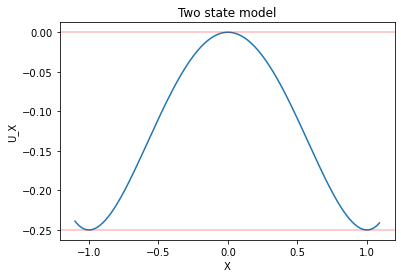

0.25


In [2]:
X=np.arange(-1.1, 1.1, 0.01)
f_X=(1-X*X)*X
U_X=-0.5*X*X+0.25*X**4
fig, (ax2) = plt.subplots(1, 1, figsize=(6, 4))
ax2.plot(X,U_X)
plt.title("Two state model")
ax2.set_xlabel('X')
ax2.set_ylabel('U_X')
ax2.axhline(max(U_X),linewidth=0.4, c="red")
ax2.axhline(min(U_X),linewidth=0.4, c="red")
plt.show()
print(max(U_X)-min(U_X))

In [4]:
N=200000
e=0.30
dt=0.05

x, y, E, t,exit_time,time_L,time_L_pos,time_L_neg=exit_times(N,dt,e,n_it=400,x_0=1,min_ex=-0.25,max_ex=0.25,t_relax=0,t_ex_min=1,delta_jump=1)

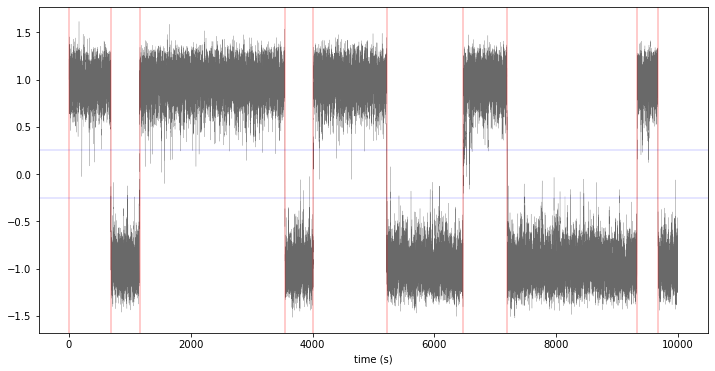

In [5]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 6))
ax1.plot(t,x,c="dimgray", linewidth=0.2)
for i in range(len(exit_time)):
    ax1.axvline(exit_time[i],linewidth=0.4, c="red")
min_ex=-0.25
max_ex=0.25
ax1.axhline(min_ex,linewidth=0.2, c="blue")
ax1.axhline(max_ex,linewidth=0.2, c="blue")
ax1.set(xlabel="time (s)")
plt.show()

# exit time distribution

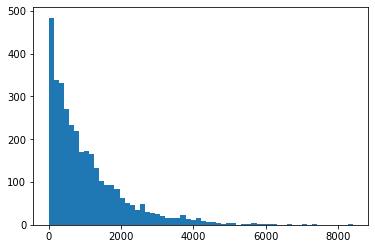

In [6]:
plt.hist(time_L,60)
plt.show()

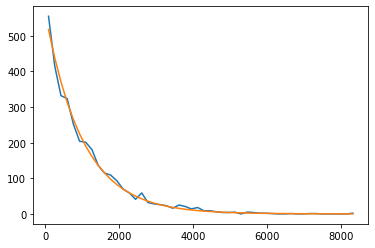

0.3 0.05 200000
mean exit time by values:  1043.8348560517038
mean exit time by interpolation:  1006.8245060766044


In [7]:
hist=np.histogram(time_L,50)
time_coord=[]
for i in range(50):
    time_coord.append((hist[1][i+1]+hist[1][i])/2)

slope, intercept, r_value, p_value, std_err = stats.linregress(time_coord[0:15],np.log(hist[0][0:15]))
x=np.array(time_coord)
plt.plot(time_coord,hist[0])
plt.plot(time_coord, np.exp(slope*x+intercept))
plt.show()
print(e, dt, N)
print("mean exit time by values: ",np.mean(time_L))
print("mean exit time by interpolation: ",1/(-slope))

# mean exit time dependence on noise intensity

correlation:  0.9998643067489327 
slope o deltaV:  0.24364122181163866


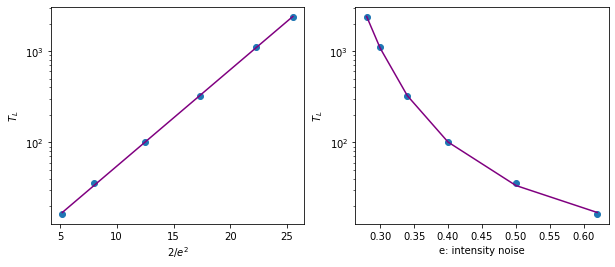

In [8]:
dt=[0.05,0.05,0.03,0.01,0.01,0.01]
N=[400000,200000,100000,100000,100000,15000]
e_vec=[0.28,0.3,0.34,0.4,0.5,0.62]
mean_exit_time_values=[2223.046407312925,1067.6603287092883,313.35800118800114,99.45406544647808,35.59965736040609,17.61388513513514]
mean_exit_time_fit=[2363.460075040231,1099.1393855972935,319.8292857675928,100.84511908844289,35.429926282623576,16.34915990998255]
e_2=np.ones(6)
for i in range(6):
    e_2[i]=2.0/e_vec[i]/e_vec[i]
    
slope, intercept, r_value, p_value, std_err = stats.linregress(e_2,np.log(mean_exit_time_fit))

print("correlation: ",r_value,"\nslope o deltaV: ",slope)
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax2.scatter(e_vec,mean_exit_time_fit)
ax2.plot(e_vec, np.exp(slope*e_2+intercept),c="purple")
ax2.set_yscale('log')
ax2.set(xlabel="e: intensity noise",ylabel="$T_L$")
ax1.scatter(e_2,mean_exit_time_fit)
ax1.plot(e_2, np.exp(slope*e_2+intercept),c="purple")
ax1.set_yscale('log')
ax1.set(xlabel="$2/e^2$",ylabel="$T_L$")
plt.show()

0.003120298159837167


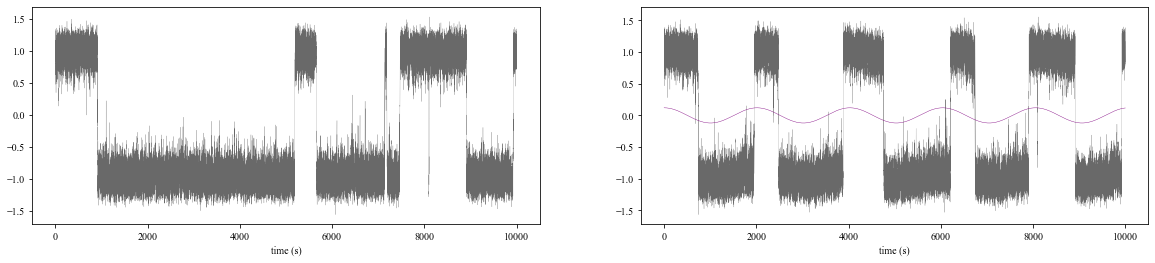

In [11]:
N=200000
e=0.3#28#42
dt=0.05
r=np.random.normal(0,1,N)
A=0.12
w=np.pi/1006.8245060766044#
print(w)#0.001501505662884648#0.044525584322049436
x=np.ones(N)
t=np.zeros(N)
x1=np.ones(N)
t1=np.zeros(N)
a=1

for i in range(N-1):
    t[i+1]=t[i]+dt
    x[i+1]=x[i]+(x[i]*(a-x[i]*x[i]))*dt+r[i]*np.sqrt(dt)*e
    x1[i+1]=x1[i]+(x1[i]*(a-x1[i]*x1[i])+A*np.cos(w*t[i]))*dt+r[i]*np.sqrt(dt)*e
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
plt.rcParams["font.family"] = "Times New Roman"
ax1.plot(t,x,c="dimgray", linewidth=0.2)
ax1.set(xlabel="time (s)")
ax2.plot(t,x1,c="dimgray", linewidth=0.2)
ax2.set(xlabel="time (s)")
b = A*np.cos(w*t)
ax2.plot(t,b,c="purple", linewidth=0.4)
plt.show()

# EBM model

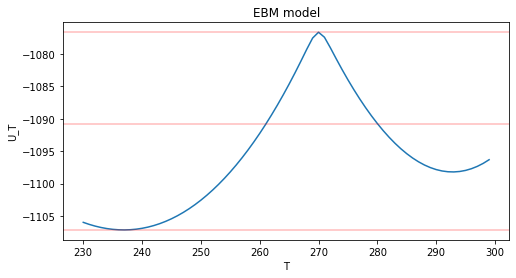

30.532390870361724 16.435165184683


In [3]:
S=10
a_0=0.5
a_1=0.4
sigma=1/180**4
temp_tilde=270
T=np.array(list(range(230,300, 1)))
f_T=S*(1-a_0+a_1/2*np.tanh(T-temp_tilde))-sigma*T**4
U_T=1.90519737844841*10**(-10)*T**5-2*np.log(np.cosh(T-temp_tilde))-5.0*T#-alpha*(E[i]/0.6/pow(F**4,1/3)-1)
fig, (ax2) = plt.subplots(1, 1, figsize=(8, 4))
ax2.plot(T,U_T)
ax2.axhline(max(U_T),linewidth=0.4, c="red")
ax2.axhline(max(U_T[50:]),linewidth=0.4, c="red")
ax2.axhline(min(U_T),linewidth=0.4, c="red")
plt.title("EBM model")
ax2.set_xlabel('T')
ax2.set_ylabel('U_T')
plt.show()
print(max(U_T)-min(U_T),max(U_T[50:])-min(U_T))

In [20]:
N15=100000
dt15=0.08
e15=0.6

x15, y15, E15, t15,exit_time15,time_L15,time_L_pos15,time_L_neg15=exit_times(N15,dt15,e15,n_it=1,x_0=400,min_ex=258,max_ex=272,t_relax=30,t_ex_min=20,delta_jump=27)

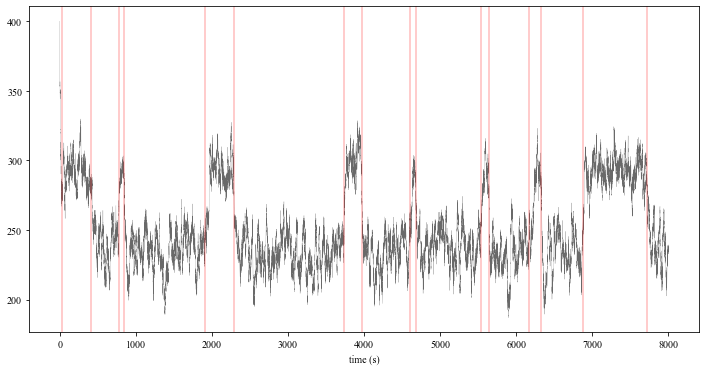

In [21]:
min_ex=258
max_ex=272
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 6))
ax1.plot(t15,x15,c="dimgray", linewidth=0.2)
for i in range(len(exit_time15)):
    ax1.axvline(exit_time15[i],linewidth=0.4, c="red")
#ax1.axhline(min_ex,linewidth=0.2, c="blue")
#ax1.axhline(max_ex,linewidth=0.2, c="blue")
ax1.set(xlabel="time (s)")
plt.show()

# exit time distribution

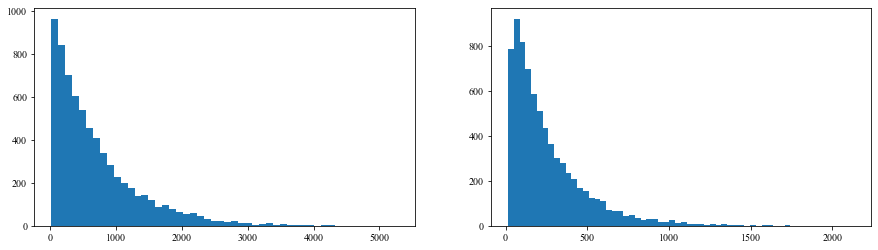

In [920]:
#fig, (ax2,ax3) = plt.subplots(1, 2, figsize=(15, 4))
#ax1.hist(time_L15,40)
ax2.hist(time_L_pos15,50)
ax3.hist(time_L_neg15,60)
plt.show()

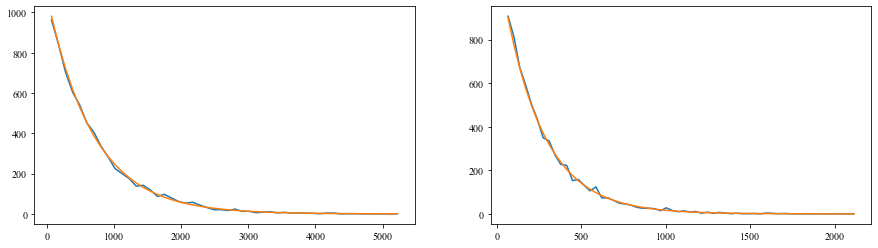

0.6 0.08 100000
tempo medio sperimentale: pos  696.2114319248826 neg  256.9902482702483
tempo medio teorico: pos  681.1296984481908 neg  234.05368615133503


In [923]:
hist_pos=np.histogram(time_L_pos15,50)
hist_neg=np.histogram(time_L_neg15,61)
time_coord_pos=np.zeros(50)
time_coord_neg=np.zeros(60)
for i in range(50):
    time_coord_pos[i]=(hist_pos[1][i]+hist_pos[1][i+1])/2
for i in range(60):
    time_coord_neg[i]=(hist_neg[1][i+1]+hist_neg[1][i+2])/2
    
slope_pos, intercept_pos, r_value_pos, p_value_pos, std_err_pos = stats.linregress(time_coord_pos[:25],np.log(hist_pos[0][:25]))
slope_neg, intercept_neg, r_value_neg, p_value_neg, std_err_neg = stats.linregress(time_coord_neg[:30],np.log(hist_neg[0][1:31]))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot(time_coord_pos,hist_pos[0])
ax1.plot(time_coord_pos, np.exp(slope_pos*time_coord_pos+intercept_pos))
ax2.plot(time_coord_neg,hist_neg[0][1:])
ax2.plot(time_coord_neg, np.exp(slope_neg*time_coord_neg+intercept_neg))
plt.show()
print(e15, dt15, N15)
print("mean exit time by values: pos ",np.mean(time_L_pos15),"neg ",np.mean(time_L_neg15))
print("mean exit time by interpolation: pos ",1/(-slope_pos),"neg ",1/(-slope_neg))

# mean exit time dependence on noise intensity

pos correlation:  0.9988923108624772 
slope:  25.840052571086787
neg correlation:  0.9995816782817329 
slope:  18.968863535417753


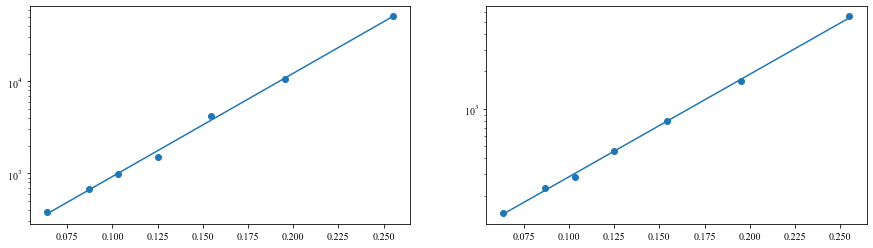

In [11]:
dt=[0.1,0.08,0.08,0.03,0.08,0.08,0.08]
N=[1200000,800000,800000,250000,100000,100000,50000]
e_vec=[0.35,0.4,0.45,0.5,0.55,0.6,0.7]
mean_exit_time_values_pos=[40313.287246346335,10741.740365023154,4237.887085235921,1475.1629497638473,986.9543485431556,696.2114319248826,396.5775631885936]#405.36163593207965]#1467.0039716312056,1456.5204996066088
mean_exit_time_fit_pos=[51066.343764075915,10741.740365023154,4174.4650948530225,1503.9809506590639,981.3072426619682,682.2927434684216,375.76112350148196]#968.898982215318questto6#393.07172470667916]# 1587.6414086675059,1564.8711565230276
mean_exit_time_values_neg=[5532.86929213711,1717.1972320826783,840.7262474428533,473.56376534174075,326.83118414693087,256.9902482702483,177.40945563012679]#178.42469699513177]#461.17035152636447,466.4376386736907,
mean_exit_time_fit_neg=[5553.97200770949,1664.4068705890536,805.152407705675,458.45399635658015,285.6462023887285,230.77265153270173,145.31144393924106]#,293.42901920634637questo6#157.0102607968893]#425.81730823695756,424.91726027003637
e_2=np.ones(7)
for i in range(7):
    e_2[i]=2.0/e_vec[i]/e_vec[i]/64
    #48598.63092873213
slope_pos, intercept_pos, r_value_pos, p_value_pos, std_err_pos = stats.linregress(e_2,np.log(mean_exit_time_fit_pos))
slope_neg, intercept_neg, r_value_neg, p_value_neg, std_err_neg = stats.linregress(e_2,np.log(mean_exit_time_fit_neg))

print("pos correlation: ",r_value_pos,"\nslope: ",slope_pos)
print("neg correlation: ",r_value_neg,"\nslope: ",slope_neg)
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.scatter(e_2,mean_exit_time_fit_pos)
ax1.plot(e_2, np.exp(slope_pos*e_2+intercept_pos))
ax1.set_yscale('log')
ax2.scatter(e_2,mean_exit_time_fit_neg)
ax2.plot(e_2, np.exp(slope_neg*e_2+intercept_neg))
ax2.set_yscale('log')
plt.show()
#8380.884784718777,,1760.6557301522007,1724.2417085924885


# EBM+L96 model

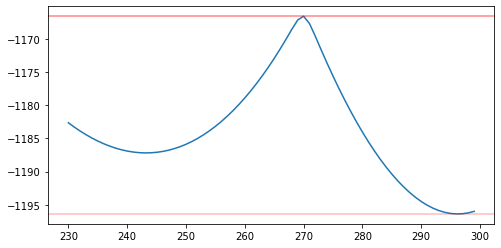

29.744462578370758 29.744462578370758


In [4]:
S=10
a_0=0.5
a_1=0.4
alpha=2
F=8
sigma=1/180**4
temp_tilde=270
T=np.array(list(range(230,300, 1)))
f_T=S*(1-a_0+a_1/2*np.tanh(T-temp_tilde))-sigma*T**4-alpha*(8/0.6/pow(F**4,1/3)-1)
U_T=1.90519737844841*10**(-10)*T**5-2*np.log(np.cosh(T-temp_tilde))-5.0*T+alpha*(8/0.6/pow(F**4,1/3)-1)*T
fig, (ax2) = plt.subplots(1, 1, figsize=(8, 4))
ax2.plot(T,U_T)
ax2.axhline(max(U_T),linewidth=0.4, c="red")
ax2.axhline(max(U_T[:50]),linewidth=0.4, c="red")
ax2.axhline(min(U_T),linewidth=0.4, c="red")
plt.show()
print(max(U_T)-min(U_T),max(U_T[:50])-min(U_T))

In [16]:
N=1200000
e=0.4
dt=0.001

x42, y42, E42, t42,exit_time42,time_L42,time_L_pos42,time_L_neg42=exit_times(N,dt,e,n_it=1,x_0=400,min_ex=258,max_ex=272,t_relax=30,t_ex_min=25,delta_jump=23)

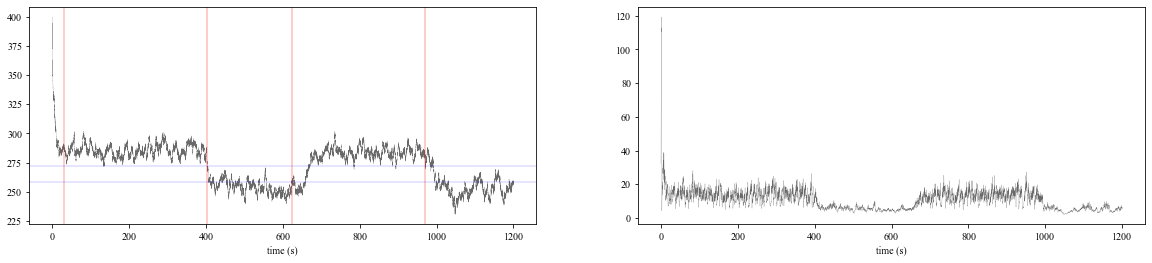

In [18]:
max_ex=272
min_ex=258
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 4))
ax1.plot(t42,x42,c="dimgray", linewidth=0.2)
for i in range(len(exit_time42)):
    ax1.axvline(exit_time42[i],linewidth=0.4, c="red")
ax1.axhline(min_ex,linewidth=0.2, c="blue")
ax1.axhline(max_ex,linewidth=0.2, c="blue")
ax1.set(xlabel="time (s)")
ax2.plot(t42,E42,c="dimgray", linewidth=0.2)
ax2.set(xlabel="time (s)")
plt.show()

# exit time distribution

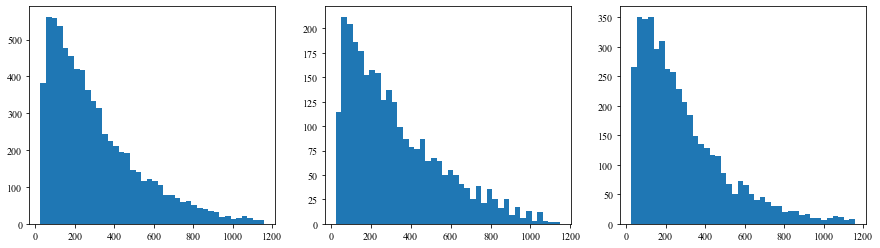

In [880]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.hist(time_L42,40)
ax2.hist(time_L_pos42,40)
ax3.hist(time_L_neg42,40)
plt.show()

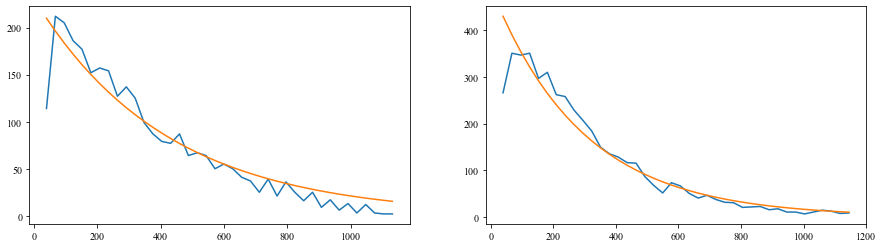

0.4 0.001 1200000
tempo medio sperimentale: pos  325.1237591879594 neg  287.85008486753486
tempo medio teorico: pos  418.18199882612873 neg  291.7186926038646


In [970]:
hist_pos=np.histogram(time_L_pos42,40)
hist_neg=np.histogram(time_L_neg42,40)
time_coord_pos=np.zeros(40)
time_coord_neg=np.zeros(40)
for i in range(40):
    time_coord_pos[i]=(hist_pos[1][i+1]+hist_pos[1][i])/2
    time_coord_neg[i]=(hist_neg[1][i+1]+hist_neg[1][i])/2
    
slope_pos, intercept_pos, r_value_pos, p_value_pos, std_err_pos = stats.linregress(time_coord_pos[:20],np.log(hist_pos[0][:20]))
slope_neg, intercept_neg, r_value_neg, p_value_neg, std_err_neg = stats.linregress(time_coord_neg[:20],np.log(hist_neg[0][:20]))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot(time_coord_pos,hist_pos[0][:])
ax1.plot(time_coord_pos, np.exp(slope_pos*time_coord_pos+intercept_pos))
ax2.plot(time_coord_neg,hist_neg[0][:])
ax2.plot(time_coord_neg, np.exp(slope_neg*time_coord_neg+intercept_neg))
plt.show()
print(e, dt, N)
print("mean exit time by values: pos ",np.mean(time_L_pos42),"neg ",np.mean(time_L_neg42))
print("mean exit time by interpolation: pos ",1/(-slope_pos),"neg ",1/(-slope_neg))

# mean exit time dependence on noise intensity

pos correlation:  0.9999017641387048 
slope:  10.055954034277635
neg correlation:  0.9999660266391032 
slope:  6.276419159249517


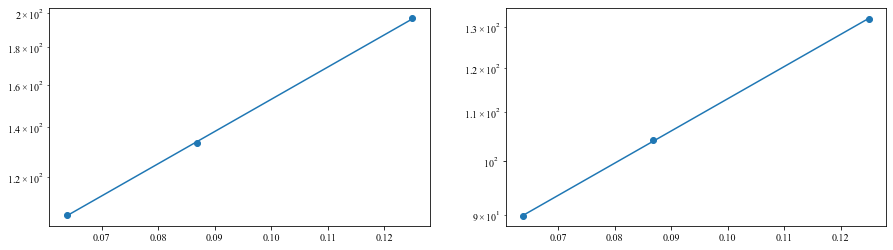

In [14]:
dt=[0.03,0.03,0.03]
N=[800000,1000000,600000]
e_vec=[0.5,0.6,0.7]
mean_exit_time_values_pos=[211.09939832444783,148.5720490131579,117.36588000000002]
mean_exit_time_fit_pos=[196.8469675550254,133.15155283400574,106.48350736782412]
mean_exit_time_values_neg=[150.73551650692227,127.88505500106179,111.73858143028846]
mean_exit_time_fit_neg=[132.0777382995437,104.18655413112768,89.89723121252123]
e_2=np.ones(3)
for i in range(3):
    e_2[i]=2.0/e_vec[i]/e_vec[i]/64
    
slope_pos, intercept_pos, r_value_pos, p_value_pos, std_err_pos = stats.linregress(e_2,np.log(mean_exit_time_fit_pos))
slope_neg, intercept_neg, r_value_neg, p_value_neg, std_err_neg = stats.linregress(e_2,np.log(mean_exit_time_fit_neg))

print("pos correlation: ",r_value_pos,"\nslope: ",slope_pos)
print("neg correlation: ",r_value_neg,"\nslope: ",slope_neg)
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.scatter(e_2,mean_exit_time_fit_pos)
ax1.plot(e_2, np.exp(slope_pos*e_2+intercept_pos))
ax1.set_yscale('log')
ax2.scatter(e_2,mean_exit_time_fit_neg)
ax2.plot(e_2, np.exp(slope_neg*e_2+intercept_neg))
ax2.set_yscale('log')
plt.show()